In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
os.makedirs("../out", exist_ok=True)

from tqdm import tqdm

# Q2: Affine Motion Subtraction

Make sure to comment your code and use proper names for your variables.

## Q2.1: Lucas-Kanade Tracking with Affine Motion

In [2]:
# We recommend using this function, but you can explore other methods as well (e.g., ndimage.shift).
from scipy.interpolate import RectBivariateSpline

# The function below could be useful as well :) 
# from numpy.linalg import lstsq

def LucasKanadeAffine(It, It1, threshold, num_iters):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[float] threshold     : If the length of dp < threshold, terminate the optimization
    :param[int] num_iters       : Number of iterations for running the optimization

    :return[np.array(2, 3)] M   : Affine warp matrix
    """
    # Initial M
    # M = np.eye(3)
    M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])
    # # TODO: Add your LK implementation here: 
    Itfn = RectBivariateSpline(np.arange(It.shape[0]), np.arange(It.shape[1]), It)
    It1fn = RectBivariateSpline(np.arange(It1.shape[0]), np.arange(It1.shape[1]), It1)
    
    p = M.flatten()
    dp = [0] * len(p)

    def threshcheck(pval):
        return np.linalg.norm(pval, ord=2)**2 < threshold
    
    x1, y1, x2, y2 = 0, 0, It.shape[0] - 1, It.shape[1] - 1 

    x = np.arange(x1, x2 + 1)
    y = np.arange(y1, y2 + 1)

    x, y = np.meshgrid(x, y)
    x = x.flatten()
    y = y.flatten()
    
    for i in range(num_iters):
        # warp
        xhat = p[0] * x + p[1] * y + p[2]
        yhat = p[3] * x + p[4] * y + p[5]

        # mask
        valid_locations = np.where((xhat >= x1) & (xhat <= x2) & (yhat >= y1) & (yhat <= y2), True, False)
        xhat = xhat[valid_locations]
        yhat = yhat[valid_locations]

        xm = x[valid_locations]
        ym = y[valid_locations]
        
        # Error image
        template = Itfn.ev(xm, ym)
        b = template - It1fn.ev(xhat, yhat)
        b = b[:, np.newaxis]

        # A calculation
        Ix = It1fn.ev(xhat, yhat, dy=0, dx=1)[:, np.newaxis]
        Iy = It1fn.ev(xhat, yhat, dy=1, dx=0)[:, np.newaxis]
        xm = xm[:, np.newaxis]
        ym = ym[:, np.newaxis]
        A = np.hstack([Ix * xm, Ix * ym, Ix, Iy * xm, Iy * ym, Iy])

        # additive update
        dp = np.linalg.lstsq(A, b, rcond=None)[0].squeeze(axis=1)
        p += dp

        if threshcheck(dp):
            break
    
    M = np.vstack((p.reshape(2, 3), [0, 0, 1]))
    return M

# Q2.2: Dominant Motion Subtraction

In [3]:
# These functions could be useful for your implementation. 
from scipy.ndimage import binary_erosion, binary_dilation, affine_transform
# import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[float] threshold     : For LucasKanadeAffine --> If the length of dp < threshold, 
                                  terminate the optimization
    :param[int] num_iters       : For LucasKanadeAffine --> Number of iterations for running the 
                                  optimization
    :param[float] tolerance     : Binary threshold of intensity difference when computing the mask.
   
    :return[np.array(H, W)] mask: Binary mask indicating moving pixels. 
    """
    # mask = np.ones(It1.shape, dtype=bool)
    # # TODO: Add your code here:
    M = LucasKanadeAffine(It, It1, threshold, num_iters)
    It_warped = affine_transform(It, M, output_shape=It.shape)
    diff = np.abs(It_warped - It1)
    moving_objects_mask = np.where(diff > tolerance, 1, 0)
    structuring_element = np.array([
        [0, 1, 0],
        [1, 1, 1],
        [0, 1, 0]
    ])
    moving_objects_mask = binary_dilation(moving_objects_mask, structuring_element, iterations=3)
    moving_objects_mask = binary_erosion(moving_objects_mask, structuring_element)
    return moving_objects_mask

## Q2.3: Track Sequence

In [4]:
def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] threshold       : If the length of dp < threshold, terminate the optimization
    :param[float] tolerance       : Binary threshold of intensity difference when computing the mask.

    :return[np.array(H, W)] mask: Binary mask indicating moving pixels.
    """
    H, W, N = seq.shape

    masks = []
    It = seq[:, :, 0]

    # TODO: Add your code here:
    for i in tqdm(range(1, seq.shape[2])):
        It = seq[:, :, i - 1]
        It1 = seq[:, :, i]
        mask = SubtractDominantMotion(It, It1, num_iters, threshold, tolerance)
        masks.append(mask)

    masks = np.stack(masks, axis=2)
    return masks

### Q2.3: Track Ant Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [5]:
seq = np.load("../data/antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = int(1e4)

threshold = 1e-2
tolerance = 0.2

masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
np.save(f'../out/antseqmasks.npy', masks)

100%|██████████| 124/124 [00:15<00:00,  7.99it/s]


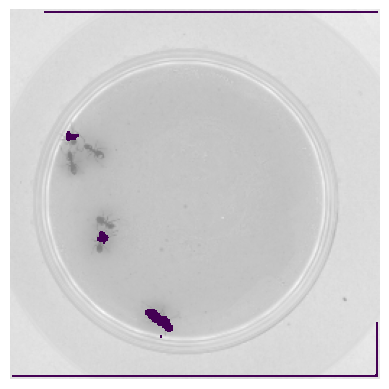

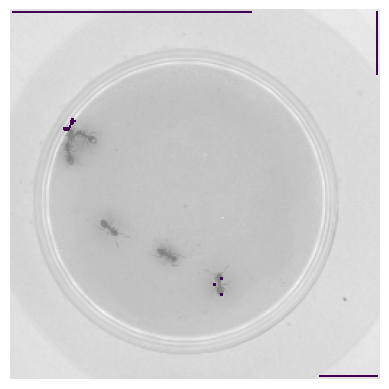

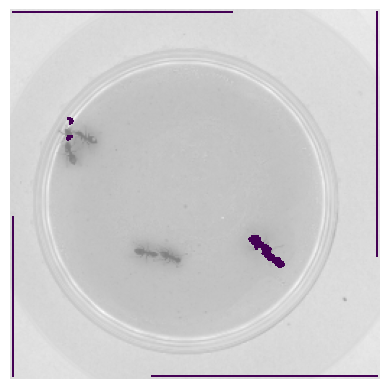

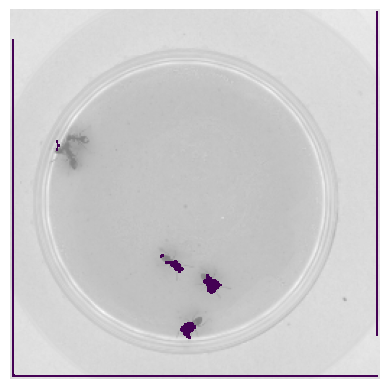

In [6]:
# TODO: visualize
frames_to_save = [30, 60, 90, 120]

for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    plt.axis('off')
    plt.savefig(f"../out/sol_2.3_antseq_{idx+1}.png")

### Q2.3: Test Aerial Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [7]:
seq = np.load("../data/aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = 1000
threshold = 0.01
tolerance = 0.2

masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
np.save(f'../out/aerialseqmasks.npy', masks)

100%|██████████| 149/149 [01:07<00:00,  2.20it/s]


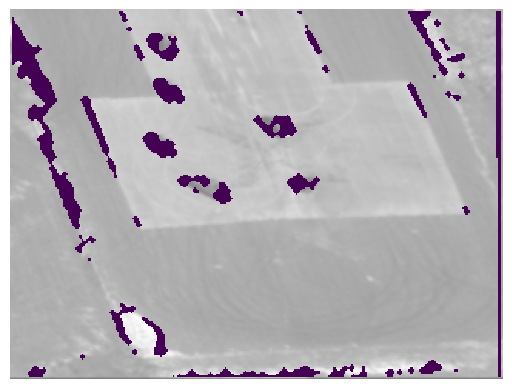

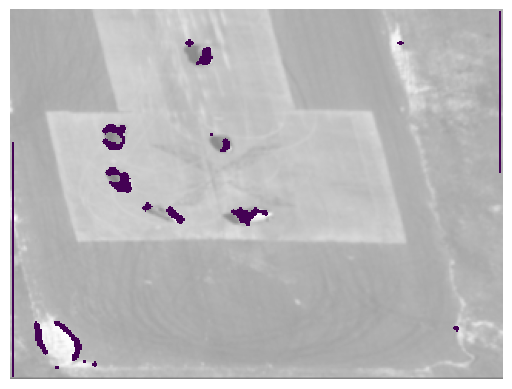

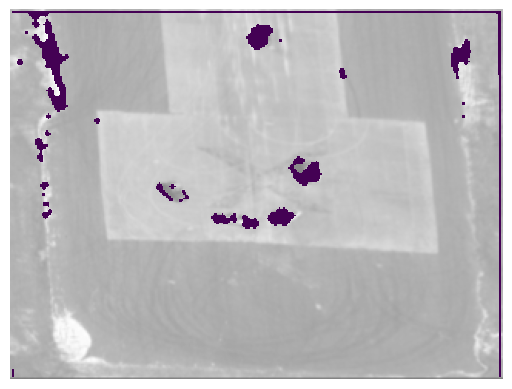

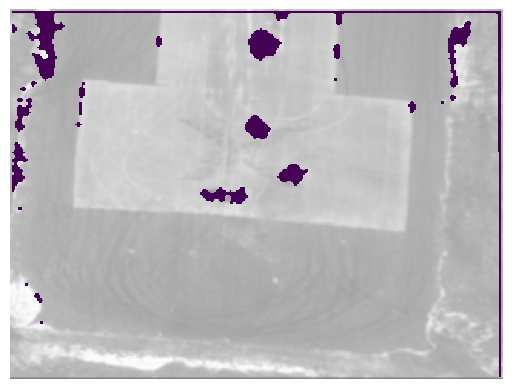

In [8]:
# TODO: visualize
frames_to_save = [30, 60, 90, 120]

for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]
   
    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    plt.axis('off')
    plt.savefig(f"../out/sol_2.3_aerialseq_{idx+1}.png")